In [1]:
using AutomotiveDrivingModels
using AutoViz
using Reactive
using Interact
using SplineUtils
using SplineRaceWay
using HierarchicalRecedingHorizonController
using NearestNeighbors

/Users/kyle/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# scene parameters
scene = Scene()
framerate = 24
Δt = 1.0/framerate # size of rendering timesteps
n_integration_sub_steps = 3 # sub steps for smoother integration
context = IntegratedContinuous(Δt, n_integration_sub_steps) # integrated continuous context

#car parameters
car_length = 4.8 # front wheel to back wheel
car_width = 2.5
v⁰  = 0.0 # initial velocity
δ⁰ = 0.0 # initical steering angle

############### INITIALIZE TRACK ################
lane_width = 30.0
radius = 45.0
edge_buffer = 0.25
T_MAX= lane_width/2.0 - car_width/2.0 - edge_buffer # max allowable projection distance from center of lane
base_speed= 0.0

# spline control points
# Pts = 50*[0 -1 -2 -3 -3.5 -3 -2 -1 -0.5 -1 -2 -3 -4 -5 -6 -6.5 -6 -5.5 -6 -6 -5 -4 -3 -2 -1.5 -1 0 1 1.5 2 3 4 5 6 6 6 7 7 7 7 6 5 4 4 4 3 2 1 0; 
#        0 0 0 0 -1 -2 -2 -2 -3 -4 -4 -4 -4 -4 -4 -3 -2 -1 0 1 2 3 4 4 3 2 2 2 3 4 4 4 4 3 2 1 0 -1 -2 -3 -4 -4 -3 -2 -1 0 0 0 0]
Pts = 50*[0 -1 -2 -3 -3.5 -3 -2 -1 -0.5 -1 -2 -3 -4 -5 -6 -6.5 -6 -5.5 -6 -6 -5 -4 -3 -2 -1.5 -1 0 1 1.5 2 3 4 5 6.25 7 7 7 7 7 7 7 6 5 4 4 4 3 2 1 0; 
       0 0 0 0 -1 -2 -2 -2 -3 -4 -4 -4 -4 -4 -4 -3 -2 -1 0 1 2 3 4 4 3 2 2 2 3 4 4 4 4 4 3 2 1 0 -1 -2 -3 -4 -4 -3 -2 -1 0 0 0 0]
degree = 3 # degree of spline
num_points = 10001
num_samples = 420

track = Raceway(Pts,degree,num_points,num_samples,lane_width)
track;

In [3]:
carcolors = Dict{Int, Colorant}()

roadind1 = RoadIndex(CurveIndex(12,0),LaneTag(1,1))
vehstate1 = VehicleState(Frenet(roadind1, track.roadway), track.roadway, 0.0)
vehdef1 = VehicleDef(1,AgentClass.CAR, car_length, car_width)
push!(scene,Vehicle(vehstate1, vehdef1))
carcolors[1] = colorant"red"
track.models[1] = mapHRHC(1,track.roadway,context,h=12,v_max=120.0,μ=30.0,a_step=12.0,a_range=[-1,0,1],k=2)

roadind2 = RoadIndex(CurveIndex(4,0),LaneTag(1,1))
vehstate2 = VehicleState(Frenet(roadind2, track.roadway), track.roadway, 0.0)
vehdef2 = VehicleDef(2,AgentClass.CAR, car_length, car_width)
push!(scene,Vehicle(vehstate2, vehdef2))
carcolors[2] = colorant"blue"
track.models[2] = mapHRHC(2,track.roadway,context,h=12,v_max=125.0,μ=32.0,a_step=12.0,a_range=[-1,0,1],k=3)

roadind3 = RoadIndex(CurveIndex(14,0),LaneTag(1,1))
vehstate3 = VehicleState(Frenet(roadind3, track.roadway), track.roadway, 0.0)
vehdef3 = VehicleDef(3,AgentClass.CAR, car_length, car_width)
push!(scene,Vehicle(vehstate3, vehdef3))
carcolors[3] = colorant"yellow"
track.models[3] = mapHRHC(3,track.roadway,context,h=12,v_max=100.0,μ=25.0,a_step=12.0,a_range=[-1,0,1],k=3)

actions = Array(DriveAction, length(scene))

track.obstacleMap = generateObstacleMap(scene, track.models)
track;

In [4]:
function drawsim(t, dt=NaN)
    k_level = 0 # needs to be updated into a loop
    for k_level in 0:maximum([model.k for (id,model) in track.models])
        for (i, veh) in enumerate(scene)
            model = track.models[veh.def.id]
            observe!(model, scene, track.roadway, veh.def.id, track.tree, track.obstacleMap, k_level)
            actions[i] = rand(model)
        end
    end
    for (veh, action) in zip(scene, actions)
        model = track.models[veh.def.id]
        context = action_context(model)
        veh.state = propagate(veh, action, context, track.roadway)
    end
#     render(scene, track.roadway, cam=FitToContentCamera(), car_colors=carcolors)
    zoom = 4.0
    render(scene, track.roadway, cam=SceneFollowCamera(zoom), car_colors=carcolors)
end

drawsim (generic function with 2 methods)

In [5]:
# ticks = fps(framerate)
# timestamps = map(_ -> time(), ticks)
# map(drawsim, timestamps)

## Demo Visualization Functions

In [5]:
function DemoMotionPrimitives()
    demoCar = mapHRHC(1,track.roadway,context,h=50,v_max=120.0,μ=30.0,a_step=12.0,a_range=[-1,0,1],k=2)

    v_idx = [50,150,220]
    δ_idx = [18,14,40]
    a_idx = [3,1,2]
    titles = ["V = 50", "V = 150", "V = 220"]
    h=12
    motion_map = demoCar.motion_map

    PyPlot.figure(figsize=[12,4])
    for i in 1:3
        PyPlot.subplot(1,3,i)
        PyPlot.axis("tight")
        PyPlot.axis("off")
        ΔXYθ = motion_map[v_idx[i]][:,:,h,:]
        trajectory = motion_map[v_idx[i]][a_idx[i],:,1:h,:]
        for j in 1:size(trajectory,1)
            PyPlot.plot(trajectory[j,:,2],trajectory[j,:,1],c="red")
        end
        PyPlot.plot(trajectory[δ_idx[i],:,2],trajectory[δ_idx[i],:,1],c="lime",linewidth=2)
        PyPlot.scatter(ΔXYθ[:,:,2],ΔXYθ[:,:,1],edgecolor="none")

        PyPlot.axis("equal")
        PyPlot.ylim([0,80])
        PyPlot.xlim([-40,40])

        PyPlot.title(titles[i])
    end
end

DemoMotionPrimitives (generic function with 1 method)

In [6]:
function DemoIncreasedHorizonBehavior()
    demoCar = mapHRHC(1,track.roadway,context,h=50,v_max=120.0,μ=30.0,a_step=12.0,a_range=[-1,0,1],k=2)
    v_idx = 220
    δ_idx = 40
    a_idx = 3
    h=demoCar.h
    motion_map = demoCar.motion_map
    PyPlot.figure()
    ΔXYθ = motion_map[v_idx][:,:,h,:]
    trajectory = motion_map[v_idx][a_idx,:,1:h,:]
    for j in 1:size(trajectory,1)
        PyPlot.plot(trajectory[j,:,2],trajectory[j,:,1],c="red")
    end
    PyPlot.plot(trajectory[δ_idx,:,2],trajectory[δ_idx,:,1],c="lime",linewidth=2)
    PyPlot.scatter(ΔXYθ[:,:,2],ΔXYθ[:,:,1],edgecolor="none")

    PyPlot.axis("tight")
    PyPlot.axis("off")
    PyPlot.axis("equal")
    PyPlot.title("Increased Horizon Behavior (V = 220)")
end

DemoIncreasedHorizonBehavior (generic function with 1 method)

In [7]:
function PlotDemoBuildingBlocks()
    t1 = linspace(-13,13,200)
    T_MAX = 10
    t_cost = exp(abs(t1/T_MAX).^6)

    ϕ1 = linspace(-Float64(π),Float64(π),200)
    ϕ_MAX = Float64(π)/2
    ϕ_cost = exp(abs(ϕ1/ϕ_MAX).^2)

    s1 = linspace(0,1,20)
    s_factor = 5
    s_cost = s_factor*(1-s1/maximum(s1))

    PyPlot.figure(figsize=[12,4])
    PyPlot.subplot(1,4,1)
    PyPlot.plot(t1/T_MAX,t_cost)
    PyPlot.ylim([0,50])
    PyPlot.title("cost(t)")
    PyPlot.subplot(1,4,2)
    PyPlot.plot(ϕ1/ϕ_MAX,ϕ_cost)
    PyPlot.ylim([0,50])
    PyPlot.title("cost(phi)")
    PyPlot.subplot(1,4,3)
    PyPlot.plot(s1,s_cost)
    PyPlot.ylim([0,50])
    PyPlot.title("cost(s)")
end

PlotDemoBuildingBlocks (generic function with 1 method)

In [8]:
function PlotObjectiveDemo(t_shift)
    θ = linspace(-Float64(π),Float64(π),360)
    r = linspace(1.0,20.0,20)
    x = [cos(i) for i in θ]*[i for i in r]'
    y = [sin(i) for i in θ]*[i for i in r]'
    R = [1 for i in θ]*[i for i in r]'
    Θ = [i for i in θ]*[1 for i in r]'
    s = x
    t = y - t_shift
    ϕ = Θ

    car_ID = 1
    s₀ = -21 # scene.vehicles[car_ID].state.posF.s

    T_MAX= 10
    ϕ_MAX = Float64(π)

    s_norm = s/maximum(s)
    t_norm = t/T_MAX
    ϕ_norm = ϕ/ϕ_MAX

    #costs
    t_cost = abs(t_norm).^6
    ϕ_cost = abs(ϕ_norm).^6
    s_factor = 1
    s_cost = s_factor*(1-s_norm)
    A = [1 .5; #  [ϕ t] [a1 a2] [ϕ]
        .5 0] #         [a2 a3] [t]
    tϕ_cost = A[1,1]*(ϕ_norm).^2 + (A[1,2]+A[2,1])*(ϕ_norm).*(t_norm) + A[2,2]*(t_norm).^2

    objective = calculateObjective(car_ID,s,s₀,t,ϕ,T_MAX)

    PyPlot.figure(figsize=[12,3])

    PyPlot.subplot(1,4,1)
    PyPlot.plot([-20,20],[T_MAX+t_shift, T_MAX+t_shift],c="black",linewidth=2)
    PyPlot.plot([-20,20],[-T_MAX+t_shift, -T_MAX+t_shift],c="black",linewidth=2)
    PyPlot.scatter(x,y,c=s_cost,edgecolor="none",s=4)
    PyPlot.axis("off")
    PyPlot.axis("equal")
    PyPlot.title("cost(s)")
    PyPlot.subplot(1,4,2)
    PyPlot.plot([-20,20],[T_MAX+t_shift, T_MAX+t_shift],c="black",linewidth=2)
    PyPlot.plot([-20,20],[-T_MAX+t_shift,-T_MAX+t_shift],c="black",linewidth=2)
    PyPlot.scatter(x,y,c=t_cost,edgecolor="none",s=4)
    PyPlot.axis("off")
    PyPlot.axis("equal")
    PyPlot.title("cost(t)")
    PyPlot.subplot(1,4,3)
    PyPlot.plot([-20,20],[T_MAX+t_shift, T_MAX+t_shift],c="black",linewidth=2)
    PyPlot.plot([-20,20],[-T_MAX+t_shift,-T_MAX+t_shift],c="black",linewidth=2)
    PyPlot.scatter(x,y,c=tϕ_cost,edgecolor="none",s=4)
    PyPlot.axis("off")
    PyPlot.axis("equal")
    PyPlot.title("cost(t,phi)")
    PyPlot.subplot(1,4,4)
    PyPlot.plot([-20,20],[T_MAX+t_shift, T_MAX+t_shift],c="black",linewidth=2)
    PyPlot.plot([-20,20],[-T_MAX+t_shift,-T_MAX+t_shift],c="black",linewidth=2)
    PyPlot.scatter(x,y,c=log(objective),edgecolor="none",s=4)
    PyPlot.scatter(x[indmin(objective)],y[indmin(objective)],c="white",s=30)
    PyPlot.axis("off")
    PyPlot.axis("equal")
    PyPlot.title("objective = cost(s,t,phi)")
end

PlotObjectiveDemo (generic function with 1 method)

In [9]:
function TailGateAvoidanceVisualization()
    θ = linspace(-Float64(π),Float64(π),360)
    r = linspace(1.0,20.0,20)
    x = [cos(i) for i in θ]*[i for i in r]'
    y = [sin(i) for i in θ]*[i for i in r]'
    R = [1 for i in θ]*[i for i in r]'
    ψ = [i for i in θ]*[1 for i in r]'

    #costs
    R_cost = 1./(2.5*R.*cos(ψ).^2 + 2*4.8*R.*sin(ψ).^2 + 1)
    # ψ_cost = 1./(R.*(sin(ψ).^2 + 1))
    ψ_cost = -cos(ψ).^3 + 1.1
    Rψ_cost = R_cost.*ψ_cost + 1

    PyPlot.figure(figsize=[12,4])

    PyPlot.subplot(1,3,1)
    PyPlot.scatter(x,y,c=R_cost,edgecolor="none",s=8)
    PyPlot.axis("equal")
    PyPlot.axis("off")
    PyPlot.title("cost(r)")
    PyPlot.subplot(1,3,2)
    PyPlot.scatter(x,y,c=ψ_cost,edgecolor="none",s=8)
    PyPlot.axis("equal")
    PyPlot.axis("off")
    PyPlot.title("cost(psi)")
    PyPlot.subplot(1,3,3)
    PyPlot.scatter(x,y,c=Rψ_cost,edgecolor="none",s=8)
    PyPlot.axis("equal")
    PyPlot.axis("off")
    PyPlot.title("cost(r,psi)")
    
    return x,y,Rψ_cost
end

TailGateAvoidanceVisualization (generic function with 1 method)

In [10]:
function ObserveActPlotObjective(track,scene;steps=50)
    for i in 1:steps
        k_level = 0 # needs to be updated into a loop
        for k_level in 0:maximum([model.k for (id,model) in track.models])
            for (i, veh) in enumerate(scene)
                model = track.models[veh.def.id]
                observe!(model, scene, track.roadway, veh.def.id, track.tree, track.obstacleMap, k_level)
                actions[i] = rand(model)
            end
        end
        for (veh, action) in zip(scene, actions)
            model = track.models[veh.def.id]
            context = action_context(model)
            veh.state = propagate(veh, action, context, track.roadway)
        end
    end
    
    PyPlot.figure(figsize=[12,8])
    
    lo = Inf
    hi = 0

    for (id,hrhc) in track.models
        lo = Int(min(lo,hrhc.curve_ind))
        hi = Int(max(hi,hrhc.curve_ind + Int(1+div(hrhc.v_range[end]*hrhc.Δt*hrhc.h,hrhc.Δs))))
        lane_width = track.roadway.segments[1].lanes[1].width

        x = zeros(hrhc.h,size(hrhc.successor_states,1),size(hrhc.successor_states,2))
        y = zeros(size(x))
        Θ = zeros(size(x))
        s = zeros(size(x))
        t = zeros(size(x))
        ϕ = zeros(size(x))
        objective = zeros(size(x))
        avoidanceCost = zeros(size(x))
        collisionFlag = zeros(size(x))

        s₀ = scene.vehicles[hrhc.car_ID].state.posF.s
        for i in 1:hrhc.h
            successor_states = getSuccessorStates(hrhc.motion_map[hrhc.v_cmd],hrhc.car_ID, i, scene)
            x[i,:,:] = copy(successor_states[:,:,1])
            y[i,:,:] = copy(successor_states[:,:,2])
            Θ[i,:,:] = copy(successor_states[:,:,3])
            s[i,:,:], t[i,:,:], ϕ[i,:,:] = loopProjectionKD(hrhc,scene,track.roadway,track.tree)
            objective[i,:,:] = calculateObjective(hrhc.car_ID,s[i,:,:],s₀,t[i,:,:],ϕ[i,:,:],hrhc.T_MAX)
            avoidanceCost[i,:,:] = TailgateAvoidance(hrhc, track.obstacleMap, track.tree, track.roadway, scene, hrhc.k)
            objective[i,:,:] = objective[i,:,:] + avoidanceCost[i,:,:]
            collisionFlag[i,:,:] = screenCollision(hrhc, track.obstacleMap, track.tree, track.roadway, scene, hrhc.k)
        end
        objective[collisionFlag .> 0] = Inf
        trajectory = track.obstacleMap[hrhc.k][hrhc.car_ID]
        
        PyPlot.scatter(x,y,c=log(objective),edgecolor="none")
        PyPlot.plot(trajectory[:,1],trajectory[:,2],color="red")
        PyPlot.axis("off")
        PyPlot.title("log objective functions of vehicles on track")
        
    end
    plotSplineRoadway(track.x[lo:hi],track.y[lo:hi],track.θ[lo:hi],lane_width)
#     return objective,avoidanceCost,collisionScreen
end

ObserveActPlotObjective (generic function with 1 method)

# Motion Primitives

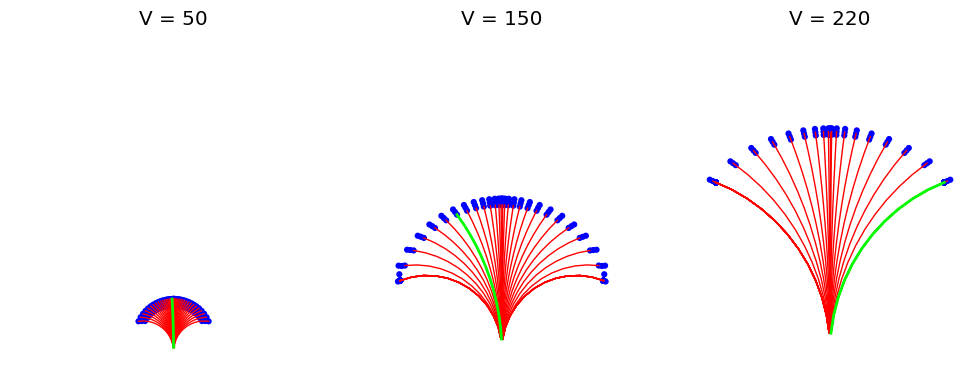

In [11]:
DemoMotionPrimitives()

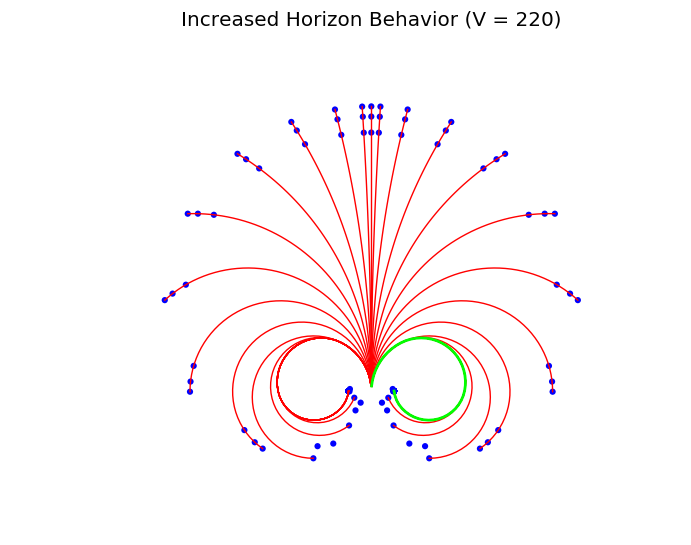

PyObject <matplotlib.text.Text object at 0x328a03810>

In [13]:
DemoIncreasedHorizonBehavior()

# Reward Shaping: Building the Objective Function

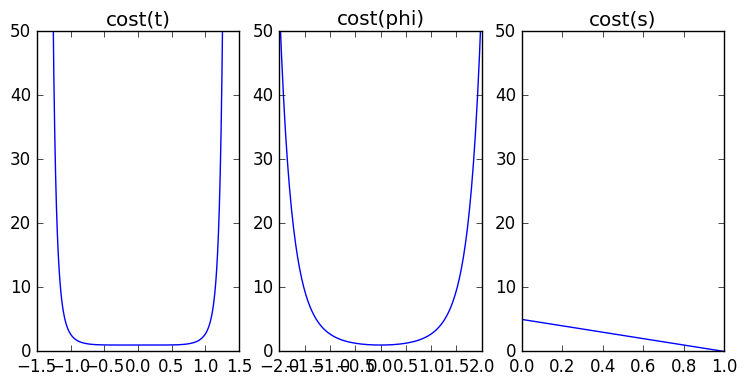

PyObject <matplotlib.text.Text object at 0x32b55a910>

In [14]:
PlotDemoBuildingBlocks()

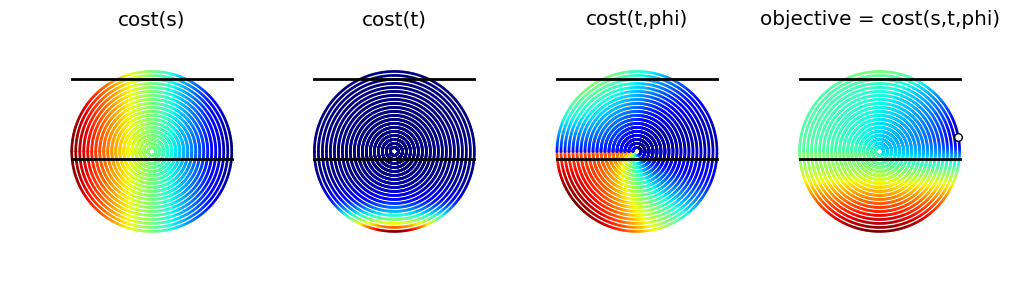

PyObject <matplotlib.text.Text object at 0x32747b710>

In [13]:
t_shift = 8
PlotObjectiveDemo(t_shift)

# Other Objective Function Visualizations

## Fixing the Tailgating Problem

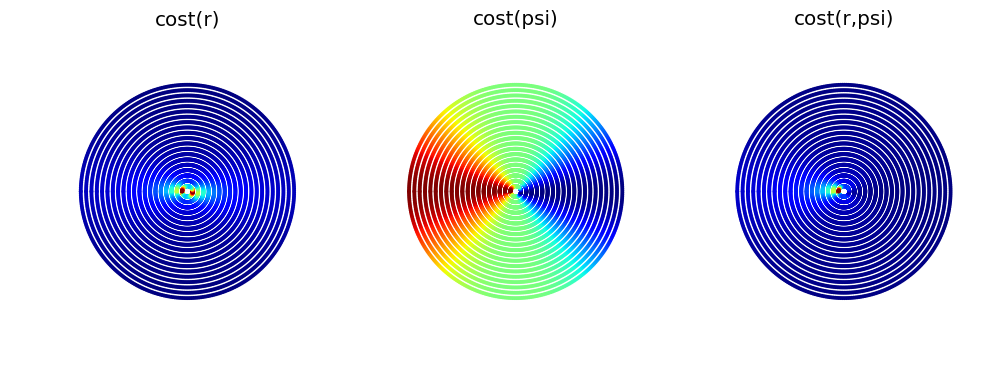

In [19]:
x,y,Rψ_cost = TailGateAvoidanceVisualization()
Rψ_cost;

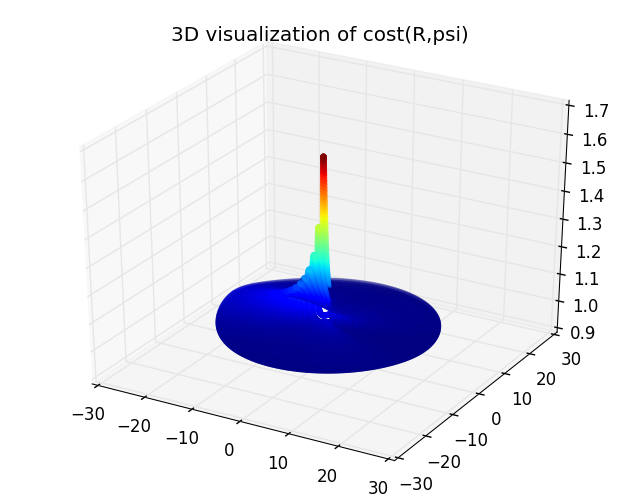

PyObject <matplotlib.text.Text object at 0x3253e1f90>

In [20]:
PyPlot.scatter3D(x,y,Rψ_cost,c=Rψ_cost,edgecolor="none")
# PyPlot.axis("off")
PyPlot.title("3D visualization of cost(R,psi)")

# Objective Function in Action

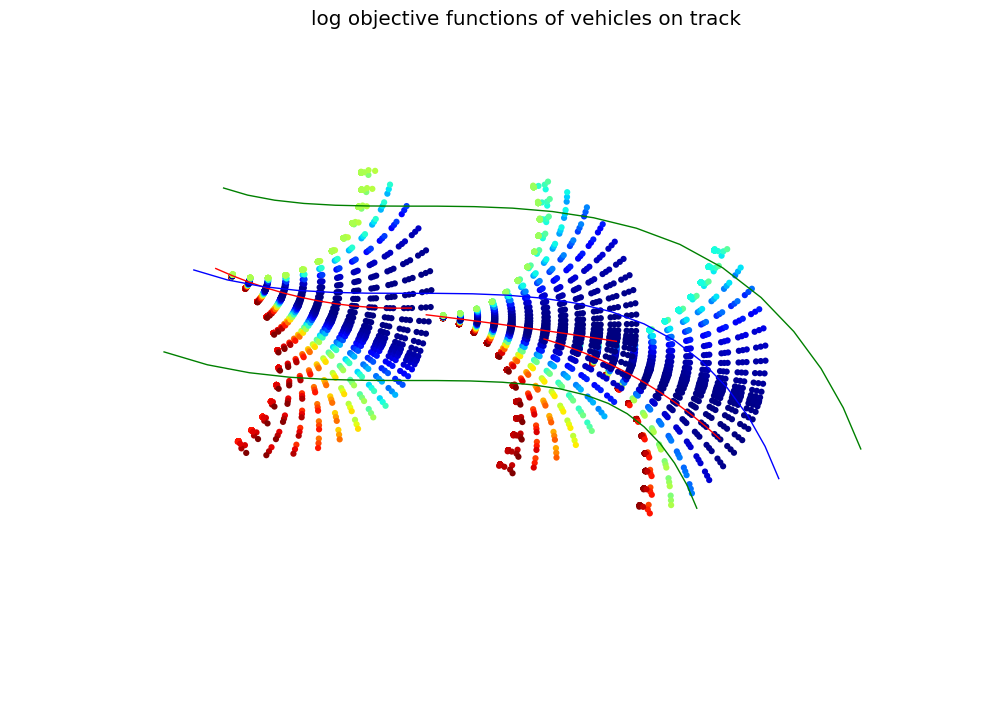

(-160.0,0.0,-150.0,-70.0)

In [16]:
ObserveActPlotObjective(track,scene,steps=50) #60, 100, 140, 180